In [35]:
import os
import sys
import csv
import pandas as pd
import numpy as np

import os.path
from os import path

import PIL
from PIL import Image

import cv2
import glob
import h5py
import os
import pathlib
import tables

import torch
from skimage import io, transform
from sklearn import metrics
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from matplotlib import pyplot

import torch
import timm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.functional import kl_div, softmax, log_softmax
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [36]:
hdf5_path = '/home/irene/ISEF-Project-2023/DensityHDF51.hdf5'
file = h5py.File(hdf5_path, "r")
file.keys()

<KeysViewHDF5 ['test_img', 'test_label', 'test_path', 'train_img', 'train_label', 'train_path', 'val_img', 'val_label', 'val_path']>

In [37]:
rgb_mean,rgb_std = (0.485, 0.456, 0.406),(0.229, 0.224, 0.225)

In [38]:
class HDF5Dataset(Dataset):


    def __init__(self, h5_path, set_name, transform = None):
        self.h5_path = h5_path
        self.dataset = None
        self.transform = transform
        self.file_path  = h5_path
        self.set = set_name
        
        str_name = self.set + "_img"
        
        file = h5py.File(h5_path, "r")
        self.dataset_len = len(file[str_name])
        
        self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(rgb_mean,rgb_std)
            ])
        
    def __getitem__(self, index): #to enable indexing
        
        if self.dataset is None:
            self.imgs = h5py.File(self.file_path, 'r')[self.set + "_img"]
            self.labels = h5py.File(self.file_path, 'r')[self.set + "_label"]
            
            cur_img = self.imgs[index]
            PIL_image = Image.fromarray(np.uint8(cur_img)).convert('RGB')#3 channels don't need alpha channel network input
            image = self.transform(PIL_image)
            label = self.labels[index].astype('float32')
            
            
        return (image,label)

    def __len__(self):
        return self.dataset_len



In [39]:
from torch.utils.data import Dataset,DataLoader

train_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="train"), batch_size=8,shuffle=True,drop_last=False)
val_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="val"), batch_size=8,shuffle=True,drop_last=False)
test_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="test"), batch_size=8,shuffle=True,drop_last=False)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


out_dim = 4

model = timm.create_model("resnet50", pretrained=True)
model.fc = nn.Linear(model.fc.in_features, out_dim)

model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay = 1e-4,momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [41]:
iterator = iter(train_loader)
total_step = len(train_loader)
print(total_step)

61


In [42]:
max_epochs = 20
def train_valid_model (net,loader):
    iterator = iter(train_loader)
    lfv_all = []
    label_all = []
    total_step = len(train_loader)
    total_step = total_step
    for step in range(total_step-1):
        images,labels = next(iterator)
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.long()

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output,labels)

        lfv = model.forward_features(images)
        print(lfv.shape)
        print(labels.shape)
        if len(lfv_all) == 0:
            lfv_all = lfv.detach().cpu().numpy()
            label_all = labels.detach().cpu().numpy()
        else:
            lfv_all = np.vstack((lfv_all, lfv.detach().cpu().numpy()))
            label_all = np.vstack((label_all, labels.detach().cpu().numpy()))
        
        print("Batch:")
        print(step)
    return lfv_all, label_all



In [43]:
max_epochs = 20
def test_valid_model (net,loader):
    iterator = iter(train_loader)
    lfv_all = []
    label_all = []
    total_step = len(train_loader)
    total_step = total_step
    for step in range(total_step-1):
        images,labels = next(iterator)
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.long()

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output,labels)

        lfv = model.forward_features(images)
        print(lfv.shape)
        print(labels.shape)
        if len(lfv_all) == 0:
            lfv_all = lfv.detach().cpu().numpy()
            label_all = labels.detach().cpu().numpy()
        else:
            lfv_all = np.vstack((lfv_all, lfv.detach().cpu().numpy()))
            label_all = np.vstack((label_all, labels.detach().cpu().numpy()))
        
        print("Batch:")
        print(step)
    return lfv_all, label_all

In [44]:
max_epochs = 20
def get_inference (net,loader):
    iterator = iter(loader)
    lfv_all = []
    label_all = []
    total_step = len(loader)
    total_step = total_step
    for step in range(total_step-1):
        images,paths = next(iterator)
        print(images)
        images = images.to(device)

        optimizer.zero_grad()

        output = model(images)
        lfv = model.forward_features(images)
        print(lfv.shape)

        if len(lfv_all) == 0:
            lfv_all = lfv.detach().cpu().numpy()
        else:
            lfv_all = np.vstack((lfv_all, lfv.detach().cpu().numpy()))
        
        print("Batch:")
        print(step)
    return lfv_all

In [57]:
x_train,y_train = train_valid_model(model, train_loader)

y_train = y_train.flatten()

torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
0
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
1
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
2
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
3
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
4
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
5
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
6
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
7
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
8
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
9
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
10
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
11
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
12
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
13
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
14
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
15
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
16
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
17
torch.Size([8, 2048, 7, 7])
torch.Size

In [58]:
x_train = np.mean(x_train, axis = 2)
x_train = np.mean(x_train, axis = 2)

In [59]:
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')
clf.fit(x_train, y_train)
print("done-fitting!")

done-fitting!


/home/irene/myenv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [60]:
x_test, y_test = test_valid_model(model, test_loader)

y_test = y_test.flatten()

torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
0
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
1
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
2
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
3
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
4
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
5
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
6
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
7
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
8
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
9
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
10
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
11
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
12
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
13
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
14
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
15
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
16
torch.Size([8, 2048, 7, 7])
torch.Size([8])
Batch:
17
torch.Size([8, 2048, 7, 7])
torch.Size

In [61]:
y_test

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 2, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 3, 3, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 2,
       1, 1, 0, 0, 2, 1, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 2, 0, 0, 0, 2, 0, 1, 0, 3,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 2, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       2, 1, 3, 0, 0, 0, 1, 0, 3, 0, 1, 1, 1, 1, 1,

In [62]:
x_test = np.mean(x_test, axis = 2)
x_test = np.mean(x_test, axis = 2)

In [63]:

y_pred = clf.predict(x_test)
print("done-predicting!")

done-predicting!


In [64]:
y_prob = clf.predict_proba(x_test)
print("done-predicting probability!")
fpr = dict()
tpr = dict()

done-predicting probability!


In [65]:
y_pred

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,

In [66]:
accuracy = accuracy_score(y_test,y_pred,normalize = True)
print(accuracy)

0.6604166666666667


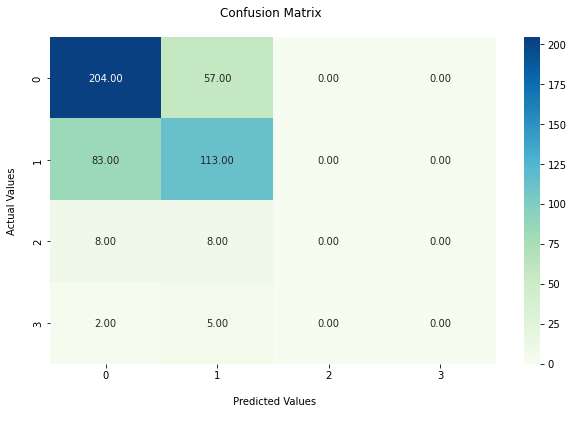

In [67]:
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');

plt.show()

In [34]:
y_pred

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,

In [55]:
y_prob

array([[1.59617524e-01, 8.04629046e-01, 3.19192563e-02, 3.83417365e-03],
       [2.08123498e-01, 7.17966459e-01, 6.40776898e-02, 9.83235355e-03],
       [1.68689137e-02, 9.73687368e-01, 5.98280807e-03, 3.46091051e-03],
       [3.26082014e-01, 5.37149917e-01, 1.25722058e-01, 1.10460107e-02],
       [6.18047728e-01, 3.74381283e-01, 5.54231764e-03, 2.02867180e-03],
       [9.93607682e-01, 5.47019968e-03, 6.32040104e-04, 2.90078068e-04],
       [9.29949001e-01, 5.38576453e-02, 1.33484643e-02, 2.84488976e-03],
       [1.31255778e-01, 8.51843286e-01, 4.09920961e-03, 1.28017264e-02],
       [1.18169192e-01, 8.56784832e-01, 1.13815332e-02, 1.36644422e-02],
       [5.79748861e-01, 3.40704790e-01, 6.80384504e-02, 1.15078981e-02],
       [2.24907093e-01, 7.62603495e-01, 8.21159391e-03, 4.27781757e-03],
       [8.22273465e-01, 1.73145559e-01, 2.37086711e-03, 2.21010924e-03],
       [6.43718864e-01, 3.27287683e-01, 1.93057094e-02, 9.68774399e-03],
       [6.96877150e-01, 2.89741554e-01, 1.17161403e

In [82]:
hdf5_path = '/home/irene/ISEF-Project-2023/Testing/NJ/DensityNJ.hdf5'
file = h5py.File(hdf5_path, "r")
file.keys()

<KeysViewHDF5 ['test_img', 'test_path']>

In [83]:
rgb_mean,rgb_std = (0.485, 0.456, 0.406),(0.229, 0.224, 0.225)

In [88]:
class HDF5Dataset(Dataset):


    def __init__(self, h5_path, set_name, transform = None):
        self.h5_path = h5_path
        self.dataset = None
        self.transform = transform
        self.file_path  = h5_path
        self.set = set_name
        
        str_name = self.set + "_img"
        
        file = h5py.File(h5_path, "r")
        self.dataset_len = len(file[str_name])
        
        self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(rgb_mean,rgb_std)
            ])
        
    def __getitem__(self, index): #to enable indexing
        
        if self.dataset is None:
            self.imgs = h5py.File(self.file_path, 'r')[self.set + "_img"]
           
            path= self.file_path
            cur_img = self.imgs[index]
            PIL_image = Image.fromarray(np.uint8(cur_img)).convert('RGB')#3 channels don't need alpha channel network input
            image = self.transform(PIL_image)

            
            
        return image, path

    def __len__(self):
        return self.dataset_len

In [89]:
from torch.utils.data import Dataset,DataLoader

test_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="test"), batch_size=8,shuffle=True,drop_last=False)

In [ ]:
x_test = get_inference(model, test_loader)


In [93]:
len(x_test)

17880

In [95]:
x_test = np.mean(x_test, axis = 2)
x_test = np.mean(x_test, axis = 2)

In [ ]:
for i in range(len(x_test)):
    print(len(x_test[i]))

In [ ]:
y_pred = clf.predict(x_test)
print("done-predicting!")

In [ ]:
len(y_pred)

In [100]:
for i in y_pred:
    print(i)

1
1
0
0
0
0
1
0
1
0
0
1
0
1
1
0
0
1
0
0
0
0
1
1
1
0
0
0
1
0
0
1
0
0
0
1
1
1
0
0
1
0
1
1
1
1
0
0
1
0
1
1
1
0
0
0
0
1
0
1
0
0
1
0
1
0
1
0
0
1
0
0
0
0
0
1
1
1
1
0
0
0
1
0
1
1
1
0
0
1
0
1
0
0
1
0
0
0
0
0
1
1
0
1
0
0
0
1
0
1
1
0
1
1
0
1
0
1
0
0
0
1
1
0
0
0
1
0
1
0
0
0
1
1
1
0
0
0
0
0
0
0
1
0
1
1
0
0
0
0
1
1
0
0
0
0
1
0
0
1
1
0
1
1
0
0
0
0
1
0
1
0
0
1
0
0
0
1
0
0
0
0
1
1
0
0
1
1
0
0
0
1
0
1
0
0
1
1
0
1
1
1
0
0
0
1
0
0
0
0
0
1
1
1
1
0
0
0
1
0
1
0
1
1
1
1
0
0
0
0
0
1
0
0
1
0
1
0
1
0
0
1
0
0
0
0
0
1
1
1
0
0
1
0
0
0
0
1
0
0
1
0
1
0
1
0
1
1
0
0
1
0
1
0
1
0
0
1
1
1
1
0
0
1
1
0
0
1
0
0
0
0
1
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
1
0
1
1
0
1
1
0
0
1
0
0
1
1
0
0
0
1
0
0
1
1
0
0
0
0
0
0
0
1
1
0
0
0
1
1
0
1
0
0
0
1
1
1
0
0
1
0
0
0
0
1
1
0
0
0
0
1
0
0
1
0
1
1
0
1
1
0
0
1
1
1
0
0
0
0
0
1
0
0
0
0
1
0
0
1
1
0
0
0
0
0
0
1
1
0
1
1
1
0
0
1
0
0
0
0
0
0
1
1
0
0
0
1
0
0
1
1
1
0
0
0
0
1
0
1
0
1
0
0
0
1
0
1
1
0
1
0
0
1
1
1
0
0
1
1
0
0
1
0
0
0
1
0
0
0
0
0
0
1
1
0
1
0
0
0
1
1
0
0
0
0
0
1
1
1
0
0
0
0
1
0
0
1
0
0
1
1
1
1
1
1


0
1
0
0
1
0
1
0
1
1
0
1
0
0
1
0
0
0
0
1
1
0
1
1
0
0
1
1
0
0
0
1
0
1
1
1
0
1
0
0
1
0
0
0
1
1
0
0
0
0
1
0
0
0
0
0
0
0
1
1
1
1
0
0
1
0
1
1
0
0
1
0
1
1
0
0
0
0
0
0
0
0
1
0
1
0
1
1
0
1
0
0
0
0
1
0
1
0
1
1
0
1
0
0
0
0
0
0
1
1
1
1
1
1
0
0
0
0
0
1
1
0
1
0
0
0
0
0
0
1
0
0
1
0
0
1
1
0
1
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
1
1
0
0
0
1
1
1
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
1
1
1
0
0
0
1
1
1
1
0
0
0
1
0
0
1
1
0
0
1
1
1
0
0
1
0
0
0
0
1
1
0
1
0
1
0
1
0
0
0
0
1
0
1
0
0
1
0
0
0
1
0
0
1
0
1
0
0
0
0
1
1
1
0
1
0
0
0
0
0
1
0
0
0
1
0
1
0
0
1
1
0
1
0
1
0
0
0
0
0
0
0
1
1
0
0
0
1
1
0
0
0
1
1
1
1
0
0
0
1
0
1
1
1
0
1
1
0
0
0
1
0
0
1
0
1
1
0
0
0
0
1
0
0
1
0
0
0
1
0
0
0
0
1
1
1
0
1
0
1
0
1
0
0
1
0
0
1
0
1
0
1
0
1
0
1
1
0
0
0
0
1
0
1
1
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
1
0
0
0
1
0
1
0
1
0
0
0
0
1
0
0
0
0
1
0
1
1
0
0
0
1
0
0
1
1
1
0
0
1
0
0
0
0
0
0
0
1
1
1
0
0
1
0
0
0
0
0
0
0
1
1
1
0
1
0
0
0
1
0
1
0
1
0
0
0
1
1
1
1
0
0
1
0
0
0
1
0
0
0
0
0
0
0
1
1
1
0
0
1
0
0
0
1
1
1
0
1
0
0
0
1
0
1
1
1
1
0
1
1
0
0
1
0
0
0
0
1
1
0
0
1
0
1
0


1
0
0
1
0
0
0
1
0
1
0
0
0
0
0
1
1
1
0
0
0
1
1
1
0
0
0
0
1
0
0
0
1
0
0
1
1
0
1
0
1
1
0
0
0
0
1
0
1
1
0
0
0
1
1
0
1
0
1
0
1
0
1
1
0
0
0
1
1
0
1
0
1
0
0
1
0
0
0
0
0
1
1
0
1
1
0
1
0
0
0
0
1
0
0
0
0
1
1
0
0
0
0
0
1
1
1
0
0
0
0
1
1
0
0
1
1
0
1
0
0
0
1
1
1
0
0
0
0
0
1
0
1
0
1
1
1
1
0
0
0
0
0
0
1
0
0
0
1
0
0
0
1
0
1
1
0
1
1
1
1
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
1
0
1
0
0
0
0
0
0
1
1
0
0
0
1
0
1
0
0
0
0
1
0
0
1
0
0
0
0
0
1
1
0
1
0
1
0
0
0
1
0
1
0
0
0
0
1
1
1
0
0
0
1
0
0
1
0
0
1
0
0
0
1
1
1
1
1
0
0
1
0
0
0
1
0
0
1
1
1
0
1
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
1
1
0
0
1
0
0
0
1
0
1
0
0
1
1
0
0
1
0
1
0
0
0
1
0
0
0
0
1
1
0
1
0
0
1
1
0
0
0
0
1
0
1
0
0
1
1
1
0
0
1
0
0
0
0
0
1
1
1
0
1
1
0
0
0
0
1
0
0
0
0
1
0
0
0
1
0
0
0
1
0
0
1
0
0
1
0
0
1
0
1
0
0
1
0
0
0
0
1
0
0
0
1
1
1
1
1
0
0
1
0
0
0
1
1
0
1
1
0
0
0
0
0
0
1
0
1
1
0
0
0
0
1
0
1
1
0
0
0
0
0
1
1
0
1
0
1
0
0
0
1
0
0
1
1
0
0
0
1
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
0
1
1
0
1
0
1
1
0
0
1
0
0
0
0
0
1
1
1
0
0
0
1
1
0
1
0
1
0
1
0
1
1
0
0
1
1
0
0
1
0
1
1
0
1
0
0
0
